In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.nn.parameter import Parameter
import torchvision
import numpy as np
from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils
from torchvision import transforms

use_cuda = False

### SNN Module

In [57]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()

        self.conv1 = snn.Convolution(6, 30, 5, 0.8, 0.05)
        self.conv1_t = 15
        self.k1 = 5
        self.r1 = 3

        self.conv2 = snn.Convolution(30, 250, 3, 0.8, 0.05)
        self.conv2_t = 10
        self.k2 = 8
        self.r2 = 1

        self.conv3 = snn.Convolution(250, 200, 5, 0.8, 0.05)

        self.stdp1 = snn.STDP(self.conv1, (0.004, -0.003))
        self.stdp2 = snn.STDP(self.conv2, (0.004, -0.003))
        self.stdp3 = snn.STDP(self.conv3, (0.004, -0.003), False, 0.2, 0.8)
        self.anti_stdp3 = snn.STDP(self.conv3, (-0.004, 0.0005), False, 0.2, 0.8)
        self.max_ap = Parameter(torch.Tensor([0.15]))

        self.decision_map = []
        for i in range(10):
            self.decision_map.extend([i]*20)

        self.ctx = {"input_spikes":None, "potentials":None, "output_spikes":None, "winners":None}
        self.spk_cnt1 = 0
        self.spk_cnt2 = 0

    def forward(self, input, max_layer):
        input = sf.pad(input.float(), (2,2,2,2), 0)
        print(f"input:\t{input.shape}")
        if self.training:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                self.spk_cnt1 += 1
                if self.spk_cnt1 >= 500:
                    self.spk_cnt1 = 0
                    ap = torch.tensor(self.stdp1.learning_rate[0][0].item(), device=self.stdp1.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp1.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k1, self.r1, spk)
                self.ctx["input_spikes"] = input
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            spk_tmp = sf.pooling(spk, 2, 2)
            spk_in = sf.pad(spk_tmp, (1,1,1,1))
            print(f"before pool:\t{spk.shape}")
            print(f"after pool:\t{spk_tmp.shape}")
            print(f"after pad:\t{spk_in.shape}")

            pot = self.conv2(spk_in)
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                self.spk_cnt2 += 1
                if self.spk_cnt2 >= 500:
                    self.spk_cnt2 = 0
                    ap = torch.tensor(self.stdp2.learning_rate[0][0].item(), device=self.stdp2.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp2.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k2, self.r2, spk)
                self.ctx["input_spikes"] = spk_in
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            spk_tmp = sf.pooling(spk, 3, 3)
            spk_in = sf.pad(spk_tmp, (2,2,2,2))
            print(f"before pool2:\t{spk.shape}")
            print(f"after pool2:\t{spk_tmp.shape}")
            print(f"after pad2:\t{spk_in.shape}")

            pot = self.conv3(spk_in)
            spk = sf.fire(pot)

            print(f"output:\t{spk.shape}")

            winners = sf.get_k_winners(pot, 1, 0, spk)
            self.ctx["input_spikes"] = spk_in
            self.ctx["potentials"] = pot
            self.ctx["output_spikes"] = spk
            self.ctx["winners"] = winners
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output
        else:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                return spk, pot
            pot = self.conv2(sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                return spk, pot
            pot = self.conv3(sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2)))
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output
    
    def stdp(self, layer_idx):
        if layer_idx == 1:
            self.stdp1(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 2:
            self.stdp2(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def update_learning_rates(self, stdp_ap, stdp_an, anti_stdp_ap, anti_stdp_an):
        self.stdp3.update_all_learning_rate(stdp_ap, stdp_an)
        self.anti_stdp3.update_all_learning_rate(anti_stdp_an, anti_stdp_ap)

    def reward(self):
        self.stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def punish(self):
        self.anti_stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

### Training/Testing functions

In [58]:
def train_unsupervise(network, data, layer_idx):
    network.train()
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        network(data_in, layer_idx)
        network.stdp(layer_idx)

def train_rl(network, data, target):
    network.train()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
                network.reward()
            else:
                perf[1]+=1
                network.punish()
        else:
            perf[2]+=1
    return perf/len(data)

def test(network, data, target):
    network.eval()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
            else:
                perf[1]+=1
        else:
            perf[2]+=1
    return perf/len(data)

### Convert to Spike Wave

In [4]:
class S1C1Transform:
    def __init__(self, filter, timesteps = 15):
        self.to_tensor = transforms.ToTensor()
        self.filter = filter
        self.temporal_transform = utils.Intensity2Latency(timesteps)
        self.cnt = 0
    def __call__(self, image):
        if self.cnt % 1000 == 0:
            print(self.cnt)
        self.cnt+=1
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0)
        image = self.filter(image)
        image = sf.local_normalization(image, 8)
        temporal_image = self.temporal_transform(image)
        return temporal_image.sign().byte()

kernels = [ utils.DoGKernel(3,3/9,6/9),
            utils.DoGKernel(3,6/9,3/9),
            utils.DoGKernel(7,7/9,14/9),
            utils.DoGKernel(7,14/9,7/9),
            utils.DoGKernel(13,13/9,26/9),
            utils.DoGKernel(13,26/9,13/9)]
filter = utils.Filter(kernels, padding = 6, thresholds = 50)
s1c1 = S1C1Transform(filter)

### Data Prep

In [5]:
data_root = "data"
MNIST_train = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform = s1c1))
MNIST_test = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform = s1c1))
MNIST_loader = DataLoader(MNIST_train, batch_size=1000, shuffle=False)
MNIST_testLoader = DataLoader(MNIST_test, batch_size=len(MNIST_test), shuffle=False)

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Train SNN

In [59]:
jack_snn = SNN()
if use_cuda:
    jack_snn.cuda()

In [61]:
for epoch in range(1):
    print("Epoch", epoch)
    iter = 0
    for data,targets in MNIST_loader:
        if iter >= 2: break
        print("Iteration", iter)
        train_unsupervise(jack_snn, data, 3)
        print("Done!")
        iter+=1

Epoch 0
Iteration 0
input:	torch.Size([15, 6, 32, 32])
before pool:	torch.Size([15, 30, 28, 28])
after pool:	torch.Size([15, 30, 14, 14])
after pad:	torch.Size([15, 30, 16, 16])
before pool2:	torch.Size([15, 250, 14, 14])
after pool2:	torch.Size([15, 250, 4, 4])
after pad2:	torch.Size([15, 250, 8, 8])
output:	torch.Size([15, 200, 4, 4])
input:	torch.Size([15, 6, 32, 32])
before pool:	torch.Size([15, 30, 28, 28])
after pool:	torch.Size([15, 30, 14, 14])
after pad:	torch.Size([15, 30, 16, 16])
before pool2:	torch.Size([15, 250, 14, 14])
after pool2:	torch.Size([15, 250, 4, 4])
after pad2:	torch.Size([15, 250, 8, 8])
output:	torch.Size([15, 200, 4, 4])
input:	torch.Size([15, 6, 32, 32])
before pool:	torch.Size([15, 30, 28, 28])
after pool:	torch.Size([15, 30, 14, 14])
after pad:	torch.Size([15, 30, 16, 16])


before pool2:	torch.Size([15, 250, 14, 14])
after pool2:	torch.Size([15, 250, 4, 4])
after pad2:	torch.Size([15, 250, 8, 8])
output:	torch.Size([15, 200, 4, 4])
input:	torch.Size([15, 6, 32, 32])
before pool:	torch.Size([15, 30, 28, 28])
after pool:	torch.Size([15, 30, 14, 14])
after pad:	torch.Size([15, 30, 16, 16])
before pool2:	torch.Size([15, 250, 14, 14])
after pool2:	torch.Size([15, 250, 4, 4])
after pad2:	torch.Size([15, 250, 8, 8])
output:	torch.Size([15, 200, 4, 4])
input:	torch.Size([15, 6, 32, 32])
before pool:	torch.Size([15, 30, 28, 28])
after pool:	torch.Size([15, 30, 14, 14])
after pad:	torch.Size([15, 30, 16, 16])
before pool2:	torch.Size([15, 250, 14, 14])
after pool2:	torch.Size([15, 250, 4, 4])
after pad2:	torch.Size([15, 250, 8, 8])
output:	torch.Size([15, 200, 4, 4])
input:	torch.Size([15, 6, 32, 32])
before pool:	torch.Size([15, 30, 28, 28])
after pool:	torch.Size([15, 30, 14, 14])
after pad:	torch.Size([15, 30, 16, 16])
before pool2:	torch.Size([15, 250, 14, 14])

KeyboardInterrupt: 

In [9]:
# Training The First Layer
print("Training the first layer")
if os.path.isfile("saved_l1.net"):
    jack_snn.load_state_dict(torch.load("saved_l1.net"))
else:
    for epoch in range(2):
        print("Epoch", epoch)
        iter = 0
        for data,targets in MNIST_loader:
            print("Iteration", iter)
            train_unsupervise(jack_snn, data, 1)
            print("Done!")
            iter+=1
    torch.save(jack_snn.state_dict(), "saved_l1.net")

Training the first layer
Epoch 0
0
Iteration 0
Done!
1000
Iteration 1
Done!
2000
Iteration 2
Done!
3000
Iteration 3
Done!
4000
Iteration 4
Done!
5000
Iteration 5
Done!
6000
Iteration 6
Done!
7000
Iteration 7
Done!
8000
Iteration 8
Done!
9000
Iteration 9
Done!
10000
Iteration 10
Done!
11000
Iteration 11
Done!
12000
Iteration 12
Done!
13000
Iteration 13
Done!
14000
Iteration 14
Done!
15000
Iteration 15
Done!
16000
Iteration 16
Done!
17000
Iteration 17
Done!
18000
Iteration 18
Done!
19000
Iteration 19
Done!
20000
Iteration 20
Done!
21000
Iteration 21
Done!
22000
Iteration 22
Done!
23000
Iteration 23
Done!
24000
Iteration 24
Done!
25000
Iteration 25
Done!
26000
Iteration 26
Done!
27000
Iteration 27
Done!
28000
Iteration 28
Done!
29000
Iteration 29
Done!
30000
Iteration 30
Done!
31000
Iteration 31
Done!
32000
Iteration 32
Done!
33000
Iteration 33
Done!
34000
Iteration 34
Done!
35000
Iteration 35
Done!
36000
Iteration 36
Done!
37000
Iteration 37
Done!
38000
Iteration 38
Done!
39000
Iteration

In [ ]:
# Training The Second Layer
print("Training the second layer")
if os.path.isfile("saved_l2.net"):
    jack_snn.load_state_dict(torch.load("saved_l2.net"))
else:
    for epoch in range(4):
        print("Epoch", epoch)
        iter = 0
        for data,targets in MNIST_loader:
            print("Iteration", iter)
            train_unsupervise(jack_snn, data, 2)
            print("Done!")
            iter+=1
    torch.save(jack_snn.state_dict(), "saved_l2.net")

In [ ]:
# initial adaptive learning rates
apr = jack_snn.stdp3.learning_rate[0][0].item()
anr = jack_snn.stdp3.learning_rate[0][1].item()
app = jack_snn.anti_stdp3.learning_rate[0][1].item()
anp = jack_snn.anti_stdp3.learning_rate[0][0].item()

adaptive_min = 0
adaptive_int = 1
apr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * apr
anr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * anr
app_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * app
anp_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * anp

# perf
best_train = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
best_test = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch

# Training The Third Layer
print("Training the third layer")
for epoch in range(680):
    print("Epoch #:", epoch)
    perf_train = np.array([0.0,0.0,0.0])
    for data,targets in MNIST_loader:
        perf_train_batch = train_rl(jack_snn, data, targets)
        print(perf_train_batch)
        #update adaptive learning rates
        apr_adapt = apr * (perf_train_batch[1] * adaptive_int + adaptive_min)
        anr_adapt = anr * (perf_train_batch[1] * adaptive_int + adaptive_min)
        app_adapt = app * (perf_train_batch[0] * adaptive_int + adaptive_min)
        anp_adapt = anp * (perf_train_batch[0] * adaptive_int + adaptive_min)
        jack_snn.update_learning_rates(apr_adapt, anr_adapt, app_adapt, anp_adapt)
        perf_train += perf_train_batch
    perf_train /= len(MNIST_loader)
    if best_train[0] <= perf_train[0]:
        best_train = np.append(perf_train, epoch)
    print("Current Train:", perf_train)
    print("   Best Train:", best_train)

    for data,targets in MNIST_testLoader:
        perf_test = test(jack_snn, data, targets)
        if best_test[0] <= perf_test[0]:
            best_test = np.append(perf_test, epoch)
            torch.save(jack_snn.state_dict(), "saved.net")
        print(" Current Test:", perf_test)
        print("    Best Test:", best_test)

In [11]:
feature = torch.stack([k() for k in kernels])
cstride= (1,1)

feature,cstride = vis.get_deep_feature(feature, cstride, (5,5), (1,1), jack_snn.conv1.weights)

feature_idx = 0
for r in range(6):
    for c in range(5):
        # ax = plt.subplot(4, 5, feature_idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        plt.imshow(feature[feature_idx].numpy(),cmap='gray')
        feature_idx += 1
        plt.show()


RuntimeError: stack expects each tensor to be equal size, but got [3, 3] at entry 0 and [7, 7] at entry 2

In [29]:
import SpykeTorch.visualization as vis

import matplotlib.pyplot as plt

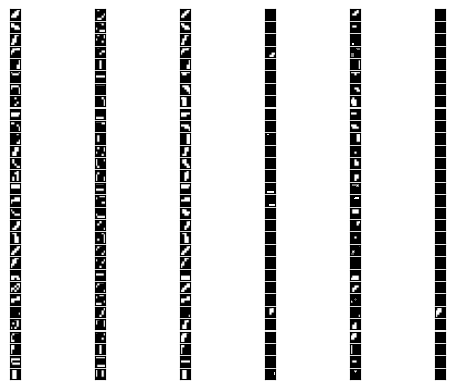

In [33]:
feature_idx = 0
for i in range(30):
    for j in range(6):
        ax = plt.subplot(30, 6, feature_idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        plt.imshow(jack_snn.conv1.weight[i][j].numpy(),cmap='gray')
        feature_idx += 1
plt.show()